In [19]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from model_util import *
from neuron_model import *

### Import data

In [20]:
df_Ch001 = pd.read_pickle(Path("../process/Ch001.pkl"))
df_Ch009 = pd.read_pickle(Path("../process/Ch009.pkl"))
df_Ch020 = pd.read_pickle(Path("../process/Ch020.pkl"))
df_Ch022 = pd.read_pickle(Path("../process/Ch022.pkl"))

### train parameters

In [21]:
#data scale config
log_noise=1
#network config
network= "cnn_v2"
model= CNN_v2()

window= 40 #for cnn_v2 only (temporal window)
#4720 possède 20 diviseurs qui sont : 1; 2; 4; 5; 8; 10; 16; 20; 40; 59; 80; 118; 236; 295; 472; 590; 944; 1180; 2360; 4720

#trainer config
batch_size= None
lr=0.01
epochs= 1000
patience= 10

#saveconfig
savename="CNN"
version="v2-w40"

### data scaling, formating, split, transform to tensor

In [22]:
df_input=[df_Ch001, df_Ch020, df_Ch009]
# log-transforming and scaling data
data_input = [data_log_scaler(df) for df in df_input]
data_target , scaler = data_log_scaler(df_Ch022, output= True)
# formatting data
data_input, data_target = data_formatter(data_input, data_target, network, window)

In [23]:
#define split to separate train and test data
split = int(len(data_input)*0.15)
print(data_input.shape, data_target.shape)

(118, 3, 40, 34) (118, 40, 34)


In [24]:
#split data into train and val
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_input[split:], data_target[split:], test_size=0.15, random_state=20)

train_size=y_train.shape[0]
val_size=y_val.shape[0]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(85, 3, 40, 34) (85, 40, 34) (16, 3, 40, 34) (16, 40, 34)


In [25]:
# transform all data to pytorch tensor
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)

In [26]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [27]:
trainset = TensorDataset(X_train, y_train)
train_loader = DataLoader(trainset, batch_size=train_size)
validationset= TensorDataset(X_val, y_val)
val_loader = DataLoader(validationset, batch_size=val_size)

### setting model, optimizer and loss

In [28]:
#defining optimizer and loss, moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [29]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [30]:
# defining the number of epochs
epochs = epochs
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [31]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [32]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [33]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### model save

In [34]:
checkpointer = ModelCheckpoint(Path('./saved_models'), savename, n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {version : model})

### Run Engine

In [35]:
trainer.run(train_loader, max_epochs=epochs)

vg loss: 0.03
Validation Results - Epoch: 200  Avg loss: 0.02
Training Results - Epoch: 201  Avg loss: 0.03
Validation Results - Epoch: 201  Avg loss: 0.02
Training Results - Epoch: 202  Avg loss: 0.03
Validation Results - Epoch: 202  Avg loss: 0.02
Training Results - Epoch: 203  Avg loss: 0.03
Validation Results - Epoch: 203  Avg loss: 0.02
Training Results - Epoch: 204  Avg loss: 0.03
Validation Results - Epoch: 204  Avg loss: 0.02
Training Results - Epoch: 205  Avg loss: 0.03
Validation Results - Epoch: 205  Avg loss: 0.02
Training Results - Epoch: 206  Avg loss: 0.03
Validation Results - Epoch: 206  Avg loss: 0.02
Training Results - Epoch: 207  Avg loss: 0.03
Validation Results - Epoch: 207  Avg loss: 0.02
Training Results - Epoch: 208  Avg loss: 0.03
Validation Results - Epoch: 208  Avg loss: 0.02
Training Results - Epoch: 209  Avg loss: 0.03
Validation Results - Epoch: 209  Avg loss: 0.02
Training Results - Epoch: 210  Avg loss: 0.03
Validation Results - Epoch: 210  Avg loss: 0.0

State:
	iteration: 411
	epoch: 411
	epoch_length: 1
	max_epochs: 1000
	output: 0.022631054744124413
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plotting the loss and accuracy

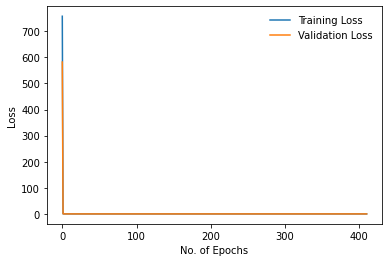

In [36]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()